In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import pandas as pd
from networkx.drawing.nx_agraph import graphviz_layout
import re
from icecream import ic


In [2]:
# load the dataframe 
title_number = "12"
# df = pd.read_csv(f"../dataframe/{title_number}.csv")
df = pd.read_parquet(f"../dataframe/{title_number}.parquet")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117306 entries, 0 to 117305
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   p_id          117306 non-null  object
 1   text          117306 non-null  object
 2   child_ids     117306 non-null  object
 3   cfr_links     117306 non-null  object
 4   other_links   117306 non-null  object
 5   link_targets  117306 non-null  object
dtypes: object(6)
memory usage: 5.4+ MB


In [3]:
# first let's do a sample
df_sample = df.sample(10)
df_sample.head()

,p_id,text,child_ids,cfr_links,other_links,link_targets
50769,308.172(b)(1),(1)An individual with a net worth of not more ...,[],[],[],[]
82178,794.110(a),"(a)The agency shall, by August 24, 1987, evalu...",[],[],[],[]
7994,22.3(a),(a)In general.A national bank or Federal savin...,[],[],[],[]
112663,1277.23(b),(b)Limitation on payment of dividends.In no ev...,[],[],[],[]
102921,1081.102(a),(a)Any term in the singular includes the plura...,[],[],[],[]


In [4]:
# Create a new directed graph
G_sample = nx.DiGraph()

for row in df_sample.itertuples():
    edges = [(row.p_id, target) for target in row.link_targets if target != []]
    children = [(row.p_id, child) for child in row.child_ids if child != []]
    G_sample.add_edges_from(edges)
    G_sample.add_edges_from(children)

In [5]:
# Define some drawing functions
def draw_simple(G,w=10,h=10):
    plt.figure(figsize=(w,h))
    pos = nx.spring_layout(G, seed=7, k=0.5, iterations=50)
    nx.draw(G, pos, with_labels=True, node_color='none', node_size=1000, edge_color='gray', linewidths=1, font_size=10)
    plt.show()

def draw_tree(G,w=10,h=10):
    plt.figure(figsize=(w,h))
    pos = graphviz_layout(G, prog='dot', args='-Goverlap=compress -Gsep=4')
    nx.draw(G, pos, with_labels=True, node_color='none', node_size=1000, edge_color='gray', linewidths=1, font_size=10)
    plt.show()

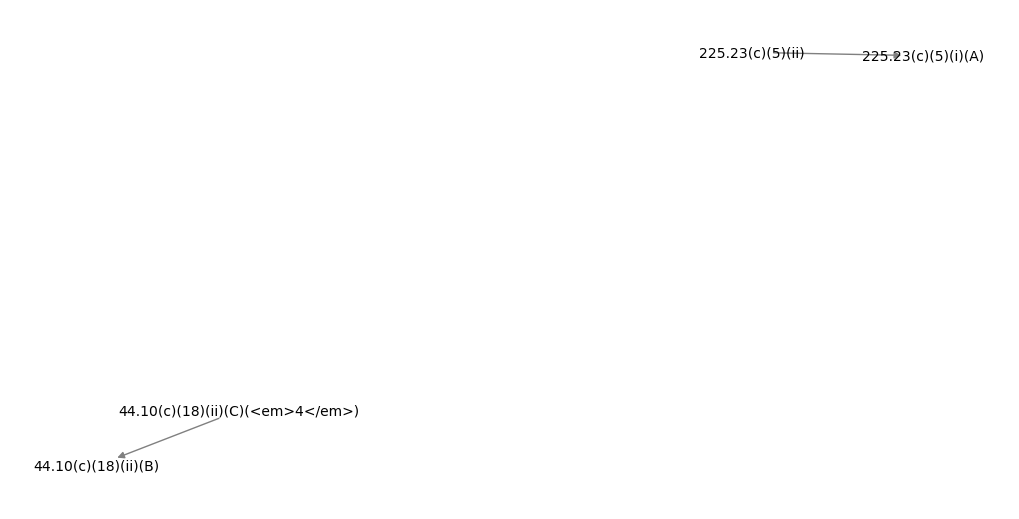

In [6]:
draw_simple(G_sample,10,5)

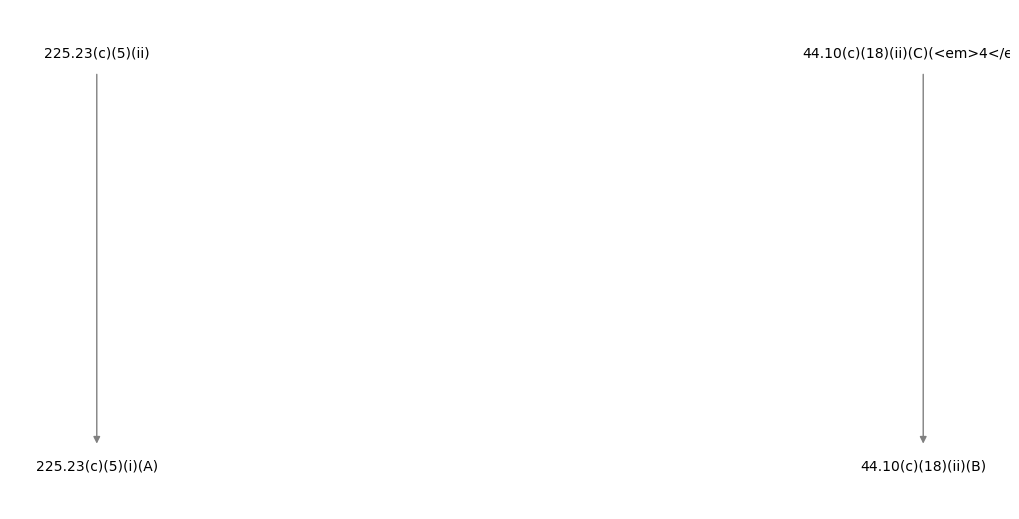

In [7]:
draw_tree(G_sample, 10, 5)

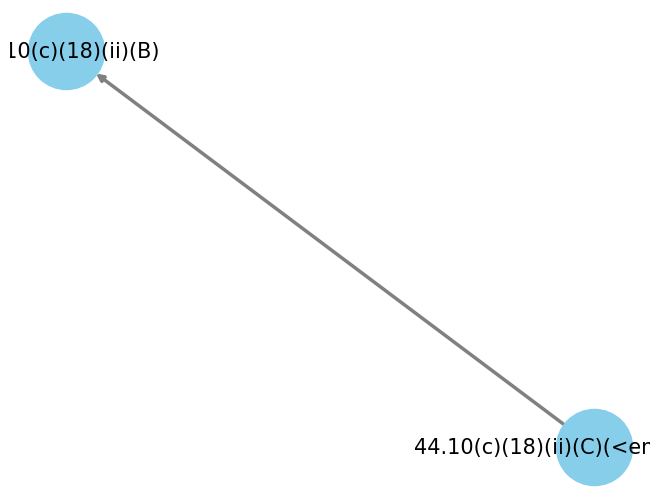

In [8]:
all_nodes = list(G_sample.nodes())
node_of_interest = random.choice(all_nodes)

# Extract the relevant nodes and edges around the random paragraph
ancestors = nx.ancestors(G_sample, node_of_interest)
descendants = nx.descendants(G_sample, node_of_interest)

# Combine the sets and add the original node
nodes_set = ancestors.union(descendants)
nodes_set.add(node_of_interest)

# Create subgraph
subgraph = G_sample.subgraph(nodes_set)

# Visualize the subgraph
pos = nx.spring_layout(subgraph, k=0.5)  # Adjust 'k' as necessary to spread out nodes
nx.draw(subgraph, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=15, width=2.5, edge_color='gray')
plt.show()

In [9]:
# now for the whole kahuna
G = nx.DiGraph()

for row in df.itertuples():
    edges = [(row.p_id, target) for target in row.link_targets if target != []]
    children = [(row.p_id, child) for child in row.child_ids if child != []]
    G.add_edges_from(edges)
    G.add_edges_from(children)

In [10]:
#some stats
print(f"Number of nodes: {G.number_of_nodes():,}")
print(f"Number of edges: {G.number_of_edges():,}")
print(f"Average degree: {(2 * G.number_of_edges()) / G.number_of_nodes():.2f}")
print(f"Density: {nx.density(G):.2f}")


Number of nodes: 111,803
Number of edges: 436,995
Average degree: 7.82
Density: 0.00


In [11]:
# let's make a subgraph of title 1.

include = '1.'
view = nx.Graph()
for u, v in G.edges():
    if u.startswith(include) or v.startswith(include):
        view.add_edge(u, v)
        
# ic(list(view.nodes()))
# ic(list(view.edges()))
print(f"Number of nodes in subgraph: {view.number_of_nodes():,}")


Number of nodes in subgraph: 187


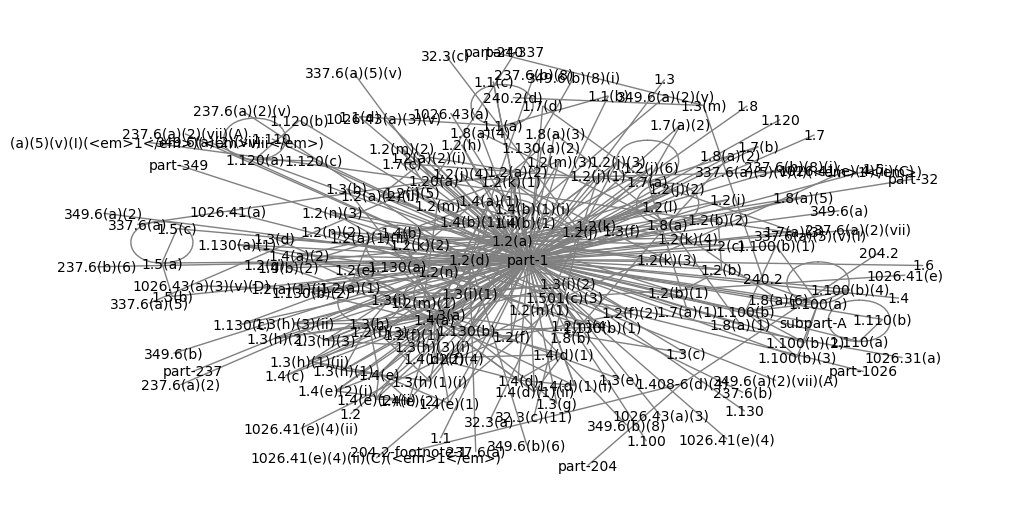

In [12]:
draw_simple(view, 10, 5)

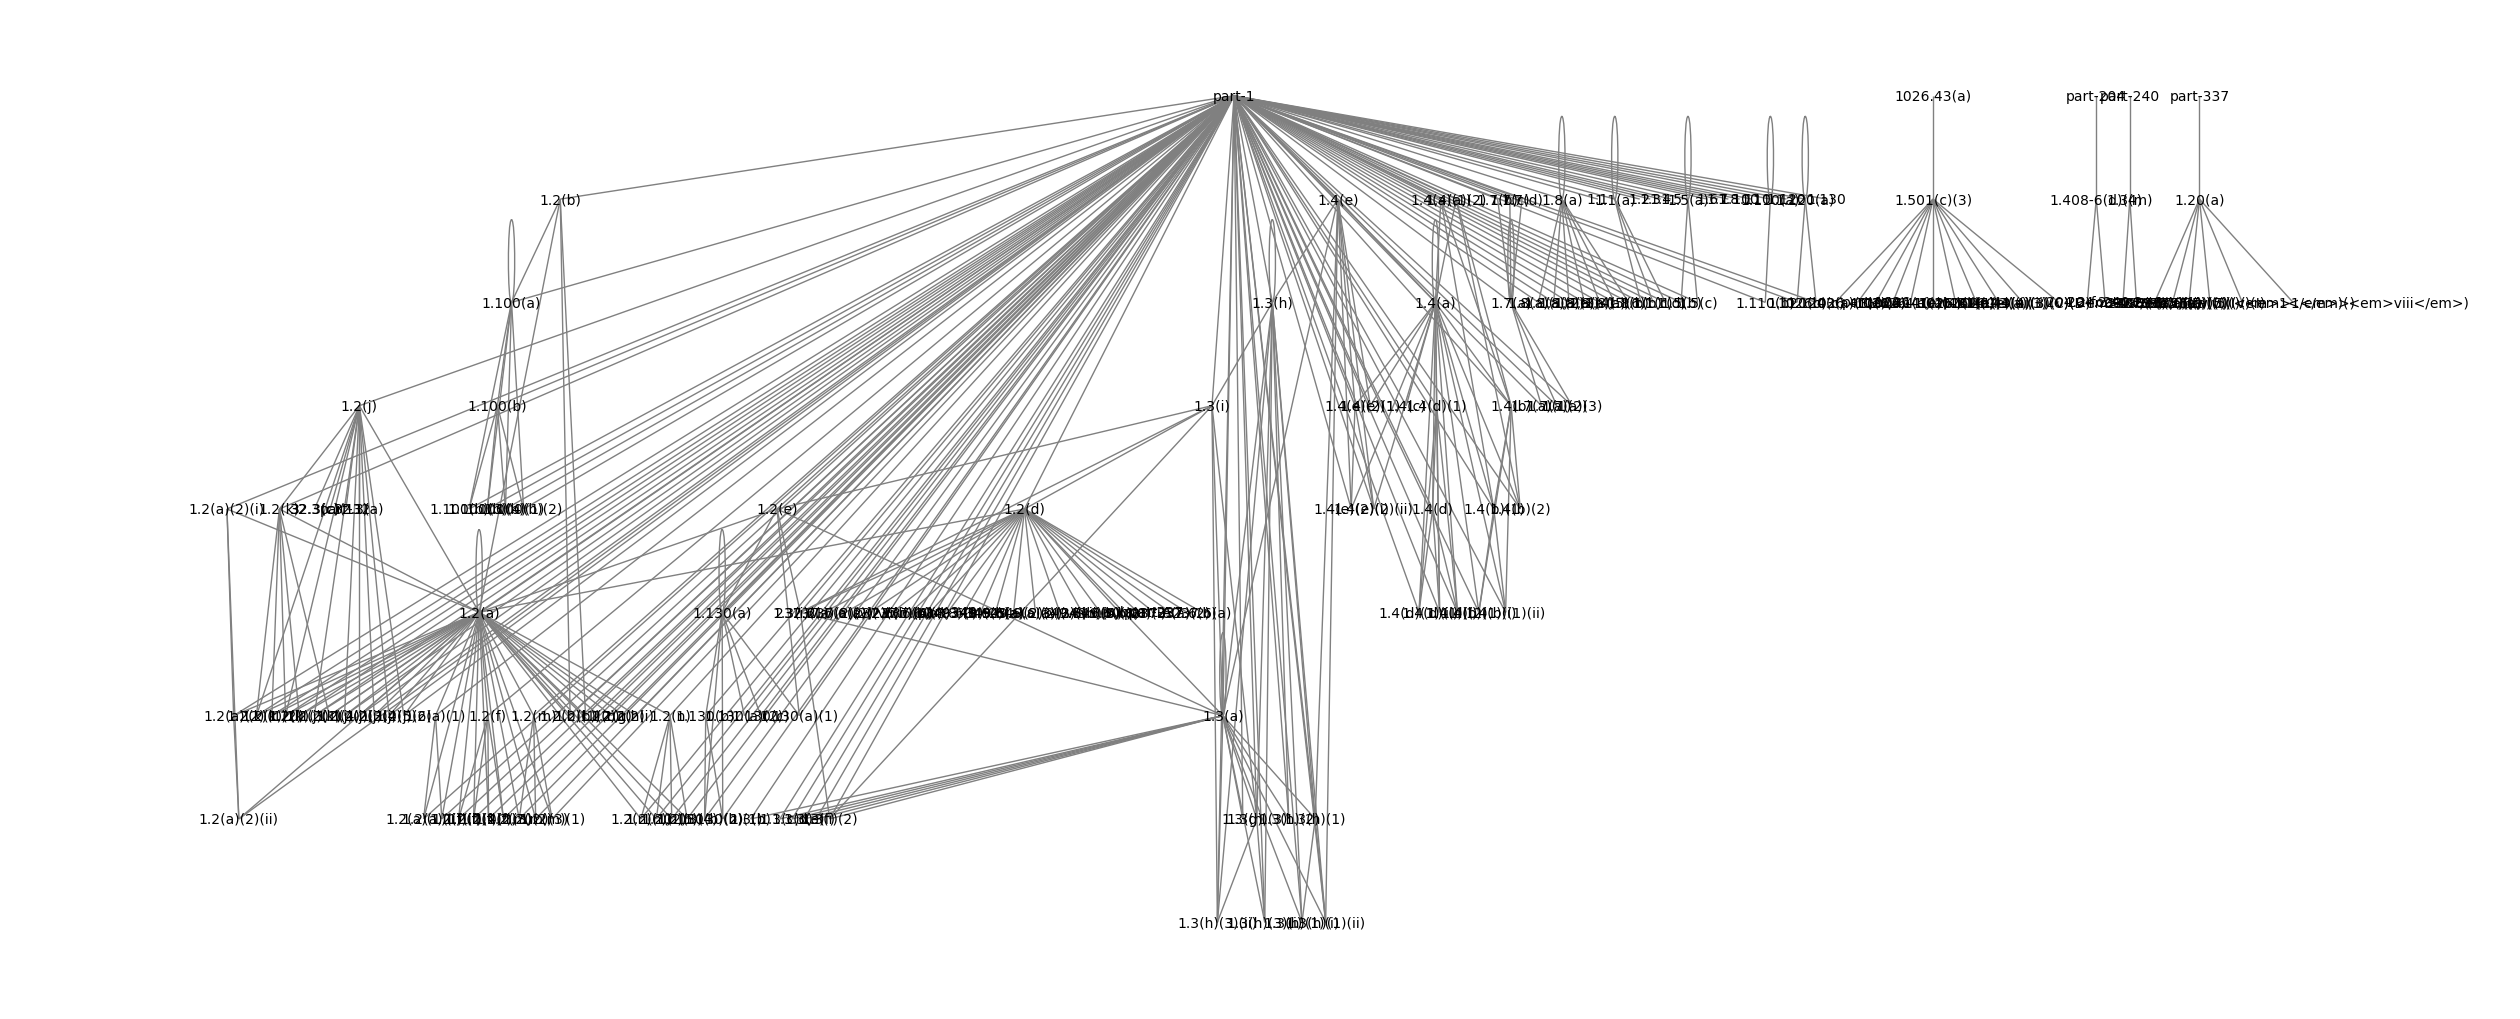

In [13]:
draw_tree(view, 25, 10)

In [14]:
# let's examine the links to other sources
other_links = sorted(list(set([item for sublist in df['other_links'] for item in sublist.tolist()])))
internal_other = [link for link in other_links if link.startswith('#')]
print(f"Number of internal other links = {len(internal_other):,}")
external_other = [link for link in other_links if not link.startswith('#')]
print(f"Number of external links = {len(external_other):,}")
pattern = r'\.(.*?)\.'
pattern = r'www\.(.*?\.[a-z]+)'
external_sources = sorted(list(set([match.group(1).lower() for link in external_other if (match := re.search(pattern, link))])))
print(f"Number of external sources = {len(external_sources):,}")
print(f"External sources:")
for e in external_sources:
    print("\t",e)


Number of internal other links = 1,502
Number of external links = 5,098
Number of external sources = 46
External sources:
	 aarmr.org
	 appraisalfoundation.org
	 archives.gov
	 asc.gov
	 banknet.gov
	 bis.org
	 bls.gov
	 census.gov
	 cfpb.gov
	 consumer.gov
	 consumerfinance.gov
	 csbs.org
	 cuna.org
	 ers.usda
	 exim.gov
	 fca.gov
	 fdic.gov
	 fdsys.gov
	 federalregister.gov
	 federalreserve.gov
	 fema.gov
	 ffiec.gov
	 fhfa.gov
	 fhfaoig.gov
	 fincen.gov
	 foia.gov
	 ftc.gov
	 govinfo.gov
	 gpoaccess.gov
	 helpwithmybank.gov
	 hud.gov
	 inclusiv.org
	 isda.org
	 justice.gov
	 msrb.org
	 nafcu.org
	 nascus.org
	 ncua.gov
	 nmlsconsumeraccess.org
	 occ.gov
	 ots.treas
	 reginfo.gov
	 stateregulatoryagency.gov
	 treasury.gov
	 whitehouse.gov
	 —.com
